In [1]:

import numpy as np
import networkx as nx
import hashlib
G = nx.read_edgelist("large_twitch_edges.csv", delimiter=',')


In [2]:
print(G)

Graph with 168114 nodes and 6797557 edges


In [3]:
def DegreeDiscountHeuristic(seed_num,G, p):
    degree_dict = {}

    for tuple in G.degree():
        degree_dict[tuple[0]] = tuple[1]
    seeds = []
    for i in range(seed_num):
        max_degree = max(degree_dict, key=degree_dict.get)
        seeds.append(max_degree)
        degree_dict.pop(max_degree)
        for node in G.neighbors(max_degree):
            if node in degree_dict:
                degree_dict[node] = degree_dict[node] - 2*(i+1) - ( degree_dict[node] - i - 1)*(i+1)*p
    return seeds
            

In [4]:
def DegreeHeuristic(seed_num,G):
    degree_heuristic = [node for (node, val) in sorted(G.degree(), reverse=True,key=lambda pair: pair[1])]
    seeds = degree_heuristic[0:seed_num]
    return seeds

In [5]:
def LIRHeuristic(seed_num,G):
    degree_dict = {}

    for tuple in G.degree():
        degree_dict[tuple[0]] = tuple[1]
    LIR_0 = []
    for i in range(seed_num):
        for node in degree_dict:
            LIR_value = 0
            for neighbor in G.neighbors(node):
                if degree_dict[node] < degree_dict[neighbor]:
                    LIR_value = LIR_value + 1
                    if LIR_value > i:
                        break
            if LIR_value == i:
                LIR_0.append([node, degree_dict[node], LIR_value])
        if len(LIR_0) >= seed_num:
                break
            
    LIR_heuristic = [(node) for (node, val, lir) in sorted(sorted(LIR_0, reverse=True,key=lambda pair: pair[1]), key=lambda pair: pair[2])]
    return LIR_heuristic[0:seed_num]


In [6]:
def propagate_nx(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)

In [7]:
def IC(G,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
                       
            targets = propagate_nx(G,p,new_active)

    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(int(hashlib.sha256(str(1000+i).encode()).hexdigest(),16)%4294967295)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread),A)

In [8]:
DDH_averages = []
Degree_averages = []
LIR_averages = []

In [ ]:
start_seed_range = 1
end_seed_range = 51
p = 0.005
permutation_num = 100

for i in range(start_seed_range, end_seed_range + 1):
    seeds_DDH = DegreeDiscountHeuristic(i,G,p)
    seeds_Degree = DegreeHeuristic(i,G)
    seeds_LIR = LIRHeuristic(i,G)
    seed_count_DDH = IC(G,seeds_DDH,p,permutation_num)
    seed_count_Degree = IC(G,seeds_Degree,p,permutation_num)
    seed_count_LIR = IC(G,seeds_LIR,p,permutation_num)
    DDH_averages.append(seed_count_DDH[0])
    Degree_averages.append(seed_count_Degree[0])
    LIR_averages.append(seed_count_LIR[0])
print(LIR_averages)

In [ ]:
print(DDH_averages)
print(Degree_averages)
print(LIR_averages)

[22393.5, 22393.64, 22388.76, 22401.51, 22410.78, 22424.84, 22406.35, 22412.08, 22411.33, 22410.41, 22427.81, 22392.43, 22399.51, 22369.1, 22414.06, 22386.95, 22390.74, 22383.04, 22392.59, 22427.37, 22376.02, 22388.9, 22396.41, 22401.21, 22403.91, 22378.2, 22392.09, 22409.0, 22421.4, 22383.68, 22392.37, 22397.79, 22399.07, 22369.4, 22373.86, 22403.33, 22392.65, 22391.45, 22381.62, 22382.71, 22404.99, 22413.51, 22384.52, 22397.77, 22379.2, 22408.43, 22398.04, 22403.11, 22412.02, 22403.74]
[22393.5, 22393.64, 22388.76, 22401.51, 22410.78, 22424.84, 22429.65, 22412.08, 22377.8, 22393.4, 22427.81, 22408.41, 22398.43, 22395.12, 22403.62, 22386.62, 22385.94, 22396.55, 22390.62, 22370.86, 22365.43, 22388.46, 22398.75, 22395.38, 22369.95, 22388.46, 22376.53, 22378.64, 22390.04, 22397.36, 22404.57, 22402.93, 22397.37, 22390.74, 22415.33, 22389.34, 22380.46, 22381.91, 22392.37, 22377.29, 22408.57, 22403.11, 22394.57, 22382.78, 22360.43, 22395.61, 22374.82, 22381.88, 22363.04, 22381.53]
[22393.5,

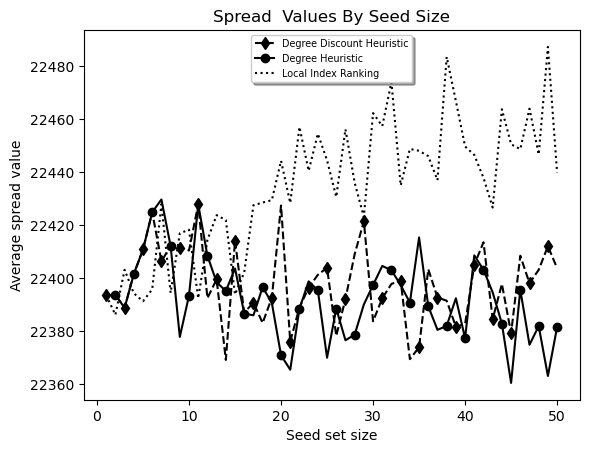

In [ ]:
import matplotlib.pyplot as plt

x = range(1, end_seed_range + 1)
fig, ax = plt.subplots()
markers_DDH = []
markers_Degree = []
for i in x:
    if i%2 == 1:
        markers_DDH.append(i - 1)
    else:
        markers_Degree.append(i - 1)
ax.plot(x, DDH_averages, 'k--d', label='Degree Discount Heuristic', markevery=markers_DDH)
ax.plot(x, Degree_averages, 'k-o',label='Degree Heuristic', markevery=markers_Degree)
ax.plot(x, LIR_averages, 'k:', label='Local Index Ranking')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-small')
legend.get_frame().set_facecolor('white')

plt.xlabel("Seed set size")
plt.ylabel("Average spread value")
plt.title('Spread  Values By Seed Size')

plt.show()

In [32]:
nx.density(G)

0.00048103610439398153

In [36]:
nx.average_clustering(G)

0.15992499330884682